[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/alucantonio/data_enhanced_simulation/blob/master/3_FlaxIntro.ipynb)

# Neural Networks with JAX: the Flax library

Flax is an open source Python neural network library built on top of JAX. Here, we will use NNX (Neural Networks for JAX), a new high-level interface that is part of Flax and provides an intuitive framework to build and train neural networks.

Link to the docs: https://flax.readthedocs.io/en/latest/quick_start.html

In [1]:
import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

from flax import nnx
import optax # optimization methods for JAX

from sklearn.model_selection import train_test_split

In [2]:
# !pip install tqdm
from tqdm.notebook import tqdm # progress bar

In [3]:
# Support for interactive plots
!pip install ipywidgets
!pip install ipympl

## A linear regression problem

To learn using NNX, let's solve a simple linear regression problem.

In [6]:
# Defining a toy dataset
n_samples = 150
x_dim = 2  # putting small numbers here so that we can visualize the data easily
y_dim = 1
noise_amplitude = 0.1

# Generate (random) parameters for a linear model
key, w_key, b_key = random.split(random.key(seed=42), num=3)
W = random.normal(w_key, (x_dim, y_dim))  # weight
b = random.normal(b_key, (y_dim,))  # bias

# Generate samples with noise added to the linear model
key, x_key, noise_key = random.split(key, num=3)
xs = random.normal(x_key, (n_samples, x_dim))
ys = jnp.dot(xs, W) + b
ys += noise_amplitude * random.normal(noise_key, (n_samples, y_dim))
print(f'xs shape = {xs.shape} ; ys shape = {ys.shape}')

xs shape = (150, 2) ; ys shape = (150, 1)


In [8]:
# Split dataset into train and test (80-20), with shuffling (default)
xs_train, xs_val, ys_train, ys_val = train_test_split(xs, ys, test_size=0.2)
xs_train.shape, xs_val.shape
ys_val.shape, ys_train.shape
# Notice that we assume that the labels are COLUMN vectors!

((30, 1), (120, 1))

To solve the linear regression problem using a neural network, let us create a subclass of the `nnx.Module` class. In particular, we have to implement the `__init__()` and `__call__()` methods.

In [9]:
# Define a custom NN
class Model(nnx.Module):
  # The constructor takes dims of inputs and outputs as parameters
  # to define hidden/output layers with the appropriate shapes
  def __init__(self, din, dout, rngs: nnx.Rngs):
    # Definition of hidden/output layers goes here
    self.linear = nnx.Linear(din, dout, rngs=rngs)

  def __call__(self, x):
    # Forward model evaluation
    return self.linear(x)

# Create a neural network by instantiating the custom class Model
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))

Basic recipe for implementing the core training functions:
- define the _loss_ function
- choose the _optimizer_ (SGD, Adam, ...)
- define a training step performing the update of model parameters for a _batch_ of training data
- define a training epoch that perform multiple batch training steps to cover all the training set

In [10]:
# Define the optimizer
lr = 0.1 # learning rate
optimizer = nnx.Optimizer(model, optax.adam(lr)) # Adam optimizer

# MSE loss
@nnx.jit
def loss_fn(model, x, y_target):
   y_pred = model(x)
   return ((y_pred - y_target) ** 2).mean()
   # You can also use losses already implemented in optax
   # return optax.losses.squared_error(predictions=y_pred, targets=y).mean()

# Training step (= one batch evaluation/params update)
@nnx.jit # jit with automatic handling of nnx objects as parameters
def train_step(model, optimizer, x, y):
  loss, grads = nnx.value_and_grad(loss_fn)(model, x, y) # get loss and gradients using JAX autodiff
  optimizer.update(grads) # update parameters of the model according to the optimizer
  return loss

# Train for a single epoch
def train_epoch(model, optimizer, xs_train, ys_train, xs_test, ys_test, batch_size, rng):
  train_ds_size = len(xs_train)
  steps_per_epoch = train_ds_size // batch_size

  perms = random.permutation(rng, len(xs_train)) # shuffle dataset (permutation of samples order)
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []

  for perm in perms:
    batch_xs = xs_train[perm, :]
    batch_ys = ys_train[perm, :]
    loss = train_step(model, optimizer, batch_xs, batch_ys)
    epoch_loss.append(loss) # store training loss for the current batch

  train_loss = np.mean(epoch_loss)
  test_loss = loss_fn(model, xs_test, ys_test)
  return model, train_loss, test_loss

Let's train the model!

In [11]:
epochs = 50
log_period_epoch = 10
batch_size = 32

train_loss_history = []
val_loss_history = []

# Training loop
for epoch in tqdm(range(1, epochs + 1)):
    model, train_loss, validation_loss = train_epoch(model, optimizer, xs_train,
                                                      ys_train, xs_val, ys_val,
                                                    batch_size, random.key(1))

    train_loss_history.append(train_loss)
    val_loss_history.append(validation_loss)

    if epoch == 1 or epoch % log_period_epoch == 0:
        print(f'epoch {epoch}, training loss = {train_loss}, test loss = {validation_loss}')

  0%|          | 0/50 [00:00<?, ?it/s]

epoch 1, training loss = 1.316292405128479, test loss = 0.8923088312149048
epoch 10, training loss = 0.05884256958961487, test loss = 0.045905351638793945
epoch 20, training loss = 0.00819326937198639, test loss = 0.01020115427672863
epoch 30, training loss = 0.008172995410859585, test loss = 0.009546172805130482
epoch 40, training loss = 0.008108782581984997, test loss = 0.009581301361322403
epoch 50, training loss = 0.008116591721773148, test loss = 0.009593135677278042


In [12]:
# Examine model parameters
print(model)

Model(
  linear=Linear(
    bias=Param(
      value=Array([-1.2324847], dtype=float32)
    ),
    bias_init=<function zeros at 0x12247ba60>,
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=2,
    kernel=Param(
      value=Array(shape=(2, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x125c82980>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
)


In [14]:
# Compare model parameters with the data-generating ones
print(model.linear.bias.value, b)
print(model.linear.kernel.value.flatten(), W.flatten())

[-1.2324847] [-1.2226542]
[-0.22509362  0.0061928 ] [-0.21746698  0.01024477]


## Hyperparameter tuning via `GridSearchCV`

In [16]:
from sklearn.utils.estimator_checks import check_is_fitted
from sklearn.base import BaseEstimator, _fit_context
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import logging
from matplotlib.pyplot import plot

In [17]:
# Split the dataset into development (train + validation) and test
X_dev, X_test, y_dev, y_test = train_test_split(xs, ys, test_size=0.1)

# Flatten y arrays to be compatible with our MLPRegressor fit method (see below)
y_dev = y_dev.ravel()
y_test = y_test.ravel()

### Auxiliary functions

In [18]:
# Train for a single epoch
@nnx.jit
def train_step(model, optimizer, x, y):
    loss, grads = nnx.value_and_grad(loss_fn)(model, x, y)
    optimizer.update(grads)
    return loss

def _train_epoch(
    model, optimizer, xs_train, ys_train, batch_size, rng
):
    train_ds_size = len(xs_train)
    steps_per_epoch = train_ds_size // batch_size

    perms = random.permutation(rng, len(xs_train))
    perms = perms[: steps_per_epoch * batch_size]
    perms = perms.reshape((steps_per_epoch, batch_size))

    epoch_loss = []

    for perm in perms:
        batch_xs = xs_train[perm, :]
        batch_ys = ys_train[perm, :]
        loss = train_step(model, optimizer, batch_xs, batch_ys)
        epoch_loss.append(loss)  # store training loss for the current batch

    train_loss = np.mean(epoch_loss)
    return model, train_loss


def train(model, optimizer, xs_train, ys_train,
          batch_size,epochs, log_period_epoch=1, show_progress=True):

    train_loss_history = []

    for epoch in tqdm(range(1, epochs + 1), disable=not show_progress):
        model, train_loss = _train_epoch(
            model, optimizer, xs_train, ys_train,
            batch_size, random.key(1),
        )

        train_loss_history.append(train_loss)

        if epoch == 1 or epoch % log_period_epoch == 0:
            logging.info(
                "epoch:% 3d, train_loss: %.4f"
                % (epoch, train_loss)
            )
    return train_loss_history

In [32]:
# adapted from template https://github.com/scikit-learn-contrib/project-template/blob/main/skltemplate/_template.py

class MLPRegressor(BaseEstimator):

    def __init__(self, model, lr, epochs, batch_size, log_period_epoch=10,
                 show_progress=True):
        self.model = model
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.log_period_epoch = log_period_epoch
        self.show_progress = show_progress

    def fit(self, X, y):
        # `_validate_data` is defined in the `BaseEstimator` class.
        # It allows to:
        # - run different checks on the input data;
        # - define some attributes associated to the input data: `n_features_in_` and
        #   `feature_names_in_`.
        X, y = self._validate_data(X, y, accept_sparse=True)

        # transform row vectors into columns to be compatible with the output of the NN
        y = y.reshape(-1, 1)

        self._optimizer = nnx.Optimizer(self.model, optax.adam(self.lr))

        self.train_loss_history = train(self.model, self._optimizer, X, y,
                                        self.batch_size, self.epochs,
                                        self.log_period_epoch, self.show_progress)

        self.is_fitted_ = True
        # `fit` should always return `self`
        return self

    def predict(self, X):
        # Check if fit had been called
        check_is_fitted(self)
        X = self._validate_data(X, accept_sparse=True, reset=False)
        return self.model(X)
    
    def score(self, X, y):
        y_pred = self.predict(X)
        return r2_score(y, y_pred)    


In [37]:
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))
m = MLPRegressor(model, 0.01, 500, 32)

In [38]:
print(X_dev.shape, y_dev.shape)
m.fit(X_dev, y_dev)
print("Training score: ", m.score(X_dev, y_dev))
print("Test score: ", m.score(X_test, y_test))

(135, 2) (135,)


  0%|          | 0/500 [00:00<?, ?it/s]

Training score:  0.846824049949646
Test score:  0.7531567215919495


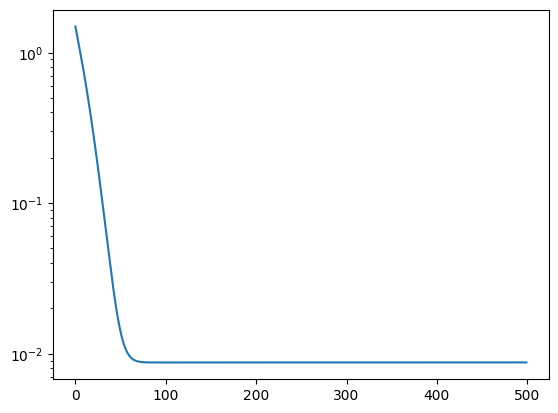

In [42]:
plot(m.train_loss_history)
plt.yscale("log")

In [43]:
m.get_params()

{'batch_size': 32,
 'epochs': 500,
 'log_period_epoch': 10,
 'lr': 0.01,
 'model': Model(
   linear=Linear(
     bias=Param(
       value=Array([-1.2393298], dtype=float32)
     ),
     bias_init=<function zeros at 0x12247ba60>,
     dot_general=<function dot_general at 0x1175aafc0>,
     dtype=None,
     in_features=2,
     kernel=Param(
       value=Array(shape=(2, 1), dtype=float32)
     ),
     kernel_init=<function variance_scaling.<locals>.init at 0x125c82980>,
     out_features=1,
     param_dtype=<class 'jax.numpy.float32'>,
     precision=None,
     use_bias=True
   )
 ),
 'show_progress': True}

In [44]:
# Define hyperparameters combinations
param_grid = {"model__lr": [0.001, 0.1], "model__batch_size": [32, 64]}

m = MLPRegressor(model, 1., 500, 32, show_progress=False)

# Apply scaling to inputs
pipeline = Pipeline([('scaler', StandardScaler()), ('model', m)])

gs = GridSearchCV(pipeline, param_grid, scoring="r2", cv=3, verbose=3)
gs.fit(X_dev, y_dev)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END model__batch_size=32, model__lr=0.001;, score=0.821 total time=   0.9s
[CV 2/3] END model__batch_size=32, model__lr=0.001;, score=0.868 total time=   0.6s
[CV 3/3] END model__batch_size=32, model__lr=0.001;, score=0.812 total time=   0.6s
[CV 1/3] END model__batch_size=32, model__lr=0.1;, score=0.820 total time=   0.6s
[CV 2/3] END model__batch_size=32, model__lr=0.1;, score=0.871 total time=   0.6s
[CV 3/3] END model__batch_size=32, model__lr=0.1;, score=0.815 total time=   0.6s
[CV 1/3] END model__batch_size=64, model__lr=0.001;, score=0.821 total time=   0.4s
[CV 2/3] END model__batch_size=64, model__lr=0.001;, score=0.868 total time=   0.4s
[CV 3/3] END model__batch_size=64, model__lr=0.001;, score=0.812 total time=   0.4s
[CV 1/3] END model__batch_size=64, model__lr=0.1;, score=0.821 total time=   0.4s
[CV 2/3] END model__batch_size=64, model__lr=0.1;, score=0.868 total time=   0.4s
[CV 3/3] END model__batch_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        MLPRegressor(batch_size=32, epochs=500,
                                                     lr=1.0,
                                                     model=Model(
  linear=Linear(
    bias=Param(
      value=Array([-1.2393298], dtype=float32)
    ),
    bias_init=<function zeros at 0x12247ba60>,
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=2,
    kernel=Param(
      value=Array(shape=(2, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x125c82980>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
),
                                                     show_progress=False))]),
             param_grid={'model__batch_size': [32, 64],
                         'model__lr': [0.001, 0.1]},
             scoring='r2', verbose=3)

In [45]:
# Best set of hyperparameters found during the grid search
gs.best_params_

{'model__batch_size': 32, 'model__lr': 0.1}

In [46]:
print("R2 for train set:", gs.score(X_dev, y_dev))
print("R2 for test set:", gs.score(X_test, y_test))

R2 for train set: 0.8467788696289062
R2 for test set: 0.7651896476745605


## Exercise: a model for concrete compressive strength

In [48]:
!pip install pandas

/Users/au731137/mambaforge/envs/datasim/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


  Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (19 kB)
  Using cached tzdata-2024.1-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.2.2-cp312-cp312-macosx_11_0_arm64.whl (11.3 MB)
Using cached tzdata-2024.1-py2.py3-none-any.whl (345 kB)


In [49]:
import pandas as pd

In [66]:
!curl -L -o ccs.csv https://raw.githubusercontent.com/alucantonio/data_enhanced_simulation/main/ccs.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    14  100    14    0     0     75      0 --:--:-- --:--:-- --:--:--    75


In [68]:
cement_df=pd.read_csv(r'Concrete Compressive Strength.csv')
cement_df.describe()

,404: Not Found
count,0
unique,0
top,NaN
freq,NaN


In [51]:
# Convert pandas data to numpy arrays
cement_X=cement_df.iloc[:,:-1].to_numpy()
cement_Y=cement_df.iloc[:,-1].to_numpy()

# Split data into development (training/validation) and test sets
X_dev, X_test, y_dev, y_test = train_test_split(cement_X, cement_Y, test_size=0.1)

1. Define a model with 4 layers (3 with activation + 1 output) by creating a derived
   class of `nnx.Module`.

In [21]:
class Model(nnx.Module):
    pass

# Create a model instance
# model = Model(...)

In [54]:
#@title Solution:

class Model(nnx.Module):
  def __init__(self, din, dout, rngs: nnx.Rngs):
    self.linear1 = nnx.Linear(din, 40, rngs=rngs)
    self.linear2 = nnx.Linear(40, 20, rngs=rngs)
    self.linear3 = nnx.Linear(20, 10, rngs=rngs)
    self.linear4 = nnx.Linear(10, dout, rngs=rngs)

  def __call__(self, x):
    y = self.linear1(x)
    y = nnx.relu(y)
    y = self.linear2(y)
    y = nnx.relu(y)
    y = self.linear3(y)
    y = nnx.relu(y)
    y = self.linear4(y)
    return y

x_dim = cement_X.shape[1]
y_dim = 1
model = Model(x_dim, y_dim, rngs=nnx.Rngs(0))

2. Train the model using the whole development set for 200 epochs, with learning rate 0.01 and batch size 64.

In [55]:
#@title Solution:

epochs = 200
batch_size = 64
lr = 0.01

m = MLPRegressor(model, lr, epochs, batch_size)

m.fit(X_dev, y_dev)

  0%|          | 0/200 [00:00<?, ?it/s]

MLPRegressor(batch_size=64, epochs=200, lr=0.01,
             model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(40,), dtype=float32)
    ),
    bias_init=<function zeros at 0x12247ba60>,
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=8,
    kernel=Param(
      value=Array(shape=(8, 40), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x125c82...
      value=Array([0.00233772], dtype=float32)
    ),
    bias_init=<function zeros at 0x12247ba60>,
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x125c82980>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
))

3. Plot the history of the training loss.

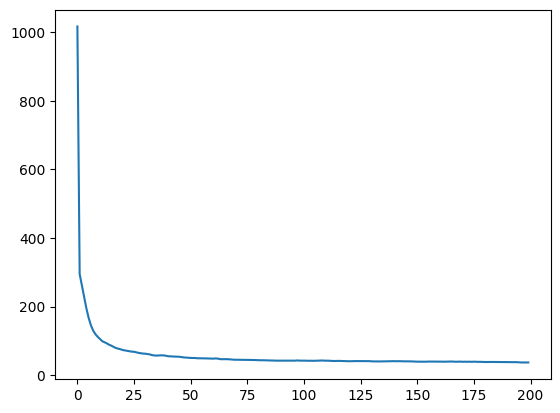

In [56]:
#@title Solution:

plt.plot(m.train_loss_history)

4. Compute the R^2 scores on the training and the test sets.

In [57]:
#@title Solution:

print("R2 for train set:", m.score(X_dev, y_dev))
print("R2 for test set:", m.score(X_test, y_test))

R2 for train set: 0.8764438355268825
R2 for test set: 0.8463476741056772


5. Perform a grid search on the learning rate and the batch size to identify the model
   with the best validation score (R^2). Print the best values of the hyperparameters.

In [58]:
param_grid = {"model__lr": [0.001, 0.1], "model__batch_size": [32, 64]}
m = MLPRegressor(model, 1., 500, 32, show_progress=False)

pipeline = Pipeline([('scaler', StandardScaler()),('model', m)])

gs = GridSearchCV(pipeline, param_grid, scoring="r2", cv=3, verbose=3)
gs.fit(X_dev, y_dev)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END model__batch_size=32, model__lr=0.001;, score=0.887 total time=  10.5s
[CV 2/3] END model__batch_size=32, model__lr=0.001;, score=0.905 total time=  10.3s
[CV 3/3] END model__batch_size=32, model__lr=0.001;, score=0.880 total time=  10.6s
[CV 1/3] END model__batch_size=32, model__lr=0.1;, score=0.695 total time=  10.8s
[CV 2/3] END model__batch_size=32, model__lr=0.1;, score=0.883 total time=  10.7s
[CV 3/3] END model__batch_size=32, model__lr=0.1;, score=0.883 total time=  10.3s
[CV 1/3] END model__batch_size=64, model__lr=0.001;, score=0.887 total time=   5.1s
[CV 2/3] END model__batch_size=64, model__lr=0.001;, score=0.894 total time=   5.2s
[CV 3/3] END model__batch_size=64, model__lr=0.001;, score=0.871 total time=   5.1s
[CV 1/3] END model__batch_size=64, model__lr=0.1;, score=0.876 total time=   5.1s
[CV 2/3] END model__batch_size=64, model__lr=0.1;, score=0.906 total time=   5.1s
[CV 3/3] END model__batch_

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model',
                                        MLPRegressor(batch_size=32, epochs=500,
                                                     lr=1.0,
                                                     model=Model(
  linear1=Linear(
    bias=Param(
      value=Array(shape=(40,), dtype=float32)
    ),
    bias_init=<function zeros at 0x12247ba60>,
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=8,
    kernel=Param(
      value=Array(shape=(8, 4...
    dot_general=<function dot_general at 0x1175aafc0>,
    dtype=None,
    in_features=10,
    kernel=Param(
      value=Array(shape=(10, 1), dtype=float32)
    ),
    kernel_init=<function variance_scaling.<locals>.init at 0x125c82980>,
    out_features=1,
    param_dtype=<class 'jax.numpy.float32'>,
    precision=None,
    use_bias=True
  )
),
                                                     show_progress=False))]),
             param_grid={'model__batch_size': [32, 64],
                         'model__lr': [0.001, 0.1]},
             scoring='r2', verbose=3)

In [59]:
gs.best_params_

{'model__batch_size': 32, 'model__lr': 0.001}

6. Compute the R^2 scores on the training and the test sets.

In [60]:
print("R2 for train set:", gs.score(X_dev, y_dev))
print("R2 for test set:", gs.score(X_test, y_test))

R2 for train set: 0.9491499796860866
R2 for test set: 0.8836799530682691


In [28]:
def predictVSactual(actual_y,y_predict,title_label):
    fig,ax=plt.subplots(1,len(actual_y),figsize=(15,15))
    for i,col in enumerate(actual_y,0):
        ax[i].plot(np.ravel(actual_y[i]),
                   np.ravel(y_predict[i]),'o',markeredgecolor="black")
        ax[i].set_title(title_label[i])
        ax[i].set_xlabel('Actual Values')
        ax[i].set_ylabel('Predicted Values')
        ax[i].set(aspect='equal')
        x=ax[i].get_xlim()
        y=ax[i].get_xlim()
        ax[i].plot(x,y, ls="--", c=".3")
    return fig,ax

In [29]:
actual_y_cement=[y_dev, y_test]
pred_y_cement=[gs.predict(X_dev),gs.predict(X_test)]

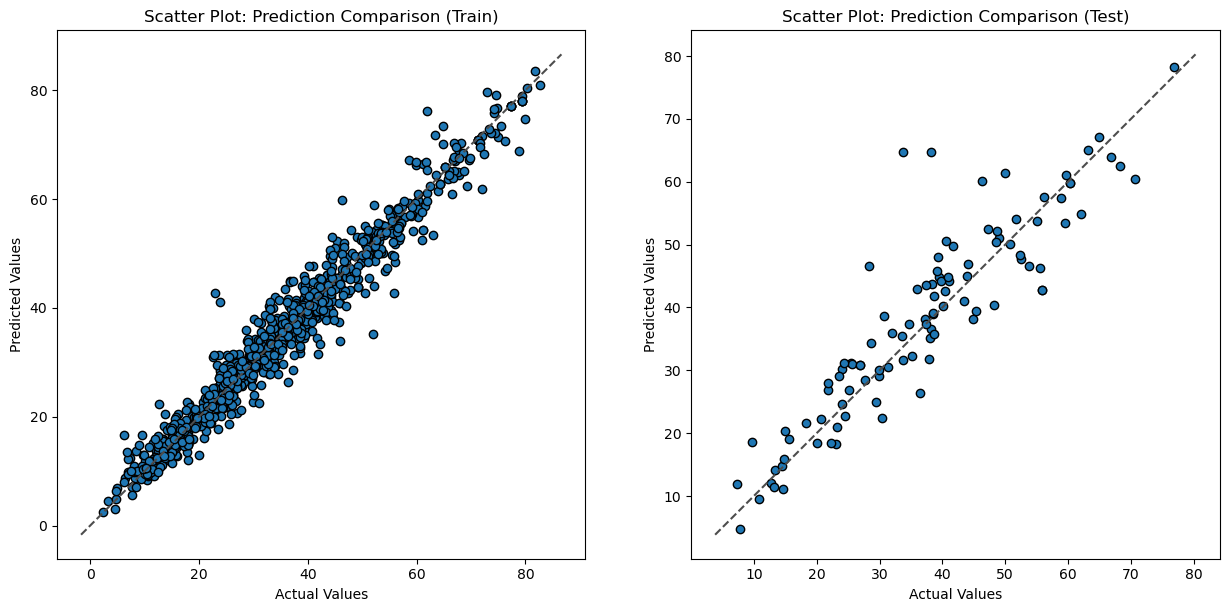

In [30]:
predictVSactual(actual_y_cement,pred_y_cement,
                ["Scatter Plot: Prediction Comparison (Train)","Scatter Plot: Prediction Comparison (Test)"])
plt.show()